In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm.notebook import tqdm
import seaborn as sns

sns.set_style("whitegrid")


In [2]:
orig_image_dir = '/kaggle/input/cavity/def-images-20250415T155900Z-001/def-images' # Original .jpg images
orig_mask_dir = '/kaggle/input/cavity/maks_images-20250415T155946Z-001/maks_images'   # Original .png masks (Accurate GT)
orig_label_dir = '/kaggle/input/cavity/def-labels-20250415T155919Z-001/def-labels' # Original .txt labels

print(f"Image Directory:    {orig_image_dir}")
print(f"Mask Directory (GT): {orig_mask_dir}")
print(f"Label Directory (Existing BBox): {orig_label_dir}")

Image Directory:    /kaggle/input/cavity/def-images-20250415T155900Z-001/def-images
Mask Directory (GT): /kaggle/input/cavity/maks_images-20250415T155946Z-001/maks_images
Label Directory (Existing BBox): /kaggle/input/cavity/def-labels-20250415T155919Z-001/def-labels


In [3]:
image_files = sorted(glob.glob(os.path.join(orig_image_dir, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(orig_mask_dir, '*.png')))
label_files = sorted(glob.glob(os.path.join(orig_label_dir, '*.txt'))) 

num_images = len(image_files)
num_masks = len(mask_files)
num_labels = len(label_files)

print(f"Found {num_images} images (.jpg)")
print(f"Found {num_masks} masks (.png)")
print(f"Found {num_labels} existing label files (.txt)")

# Check basenames
image_basenames = {os.path.splitext(os.path.basename(f))[0] for f in image_files}
mask_basenames = {os.path.splitext(os.path.basename(f))[0] for f in mask_files}
label_basenames = {os.path.splitext(os.path.basename(f))[0] for f in label_files}

# Find images that have all three components
common_basenames = image_basenames.intersection(mask_basenames).intersection(label_basenames)
print(f"\nFound {len(common_basenames)} samples with corresponding Image, Mask, and Label file.")

data_info_list = []
img_map = {os.path.splitext(os.path.basename(f))[0]: f for f in image_files}
mask_map = {os.path.splitext(os.path.basename(f))[0]: f for f in mask_files}
label_map = {os.path.splitext(os.path.basename(f))[0]: f for f in label_files}

for name in common_basenames:
    data_info_list.append({
        'name': name,
        'image_path': img_map.get(name),
        'mask_path': mask_map.get(name),
        'label_path': label_map.get(name) # Path to existing .txt label
    })

print(f"\nCreated list with info for {len(data_info_list)} fully matched samples.")

Found 300 images (.jpg)
Found 300 masks (.png)
Found 300 existing label files (.txt)

Found 300 samples with corresponding Image, Mask, and Label file.

Created list with info for 300 fully matched samples.



Displaying 5 samples: Image vs GT Mask vs Existing BBox vs GT BBox


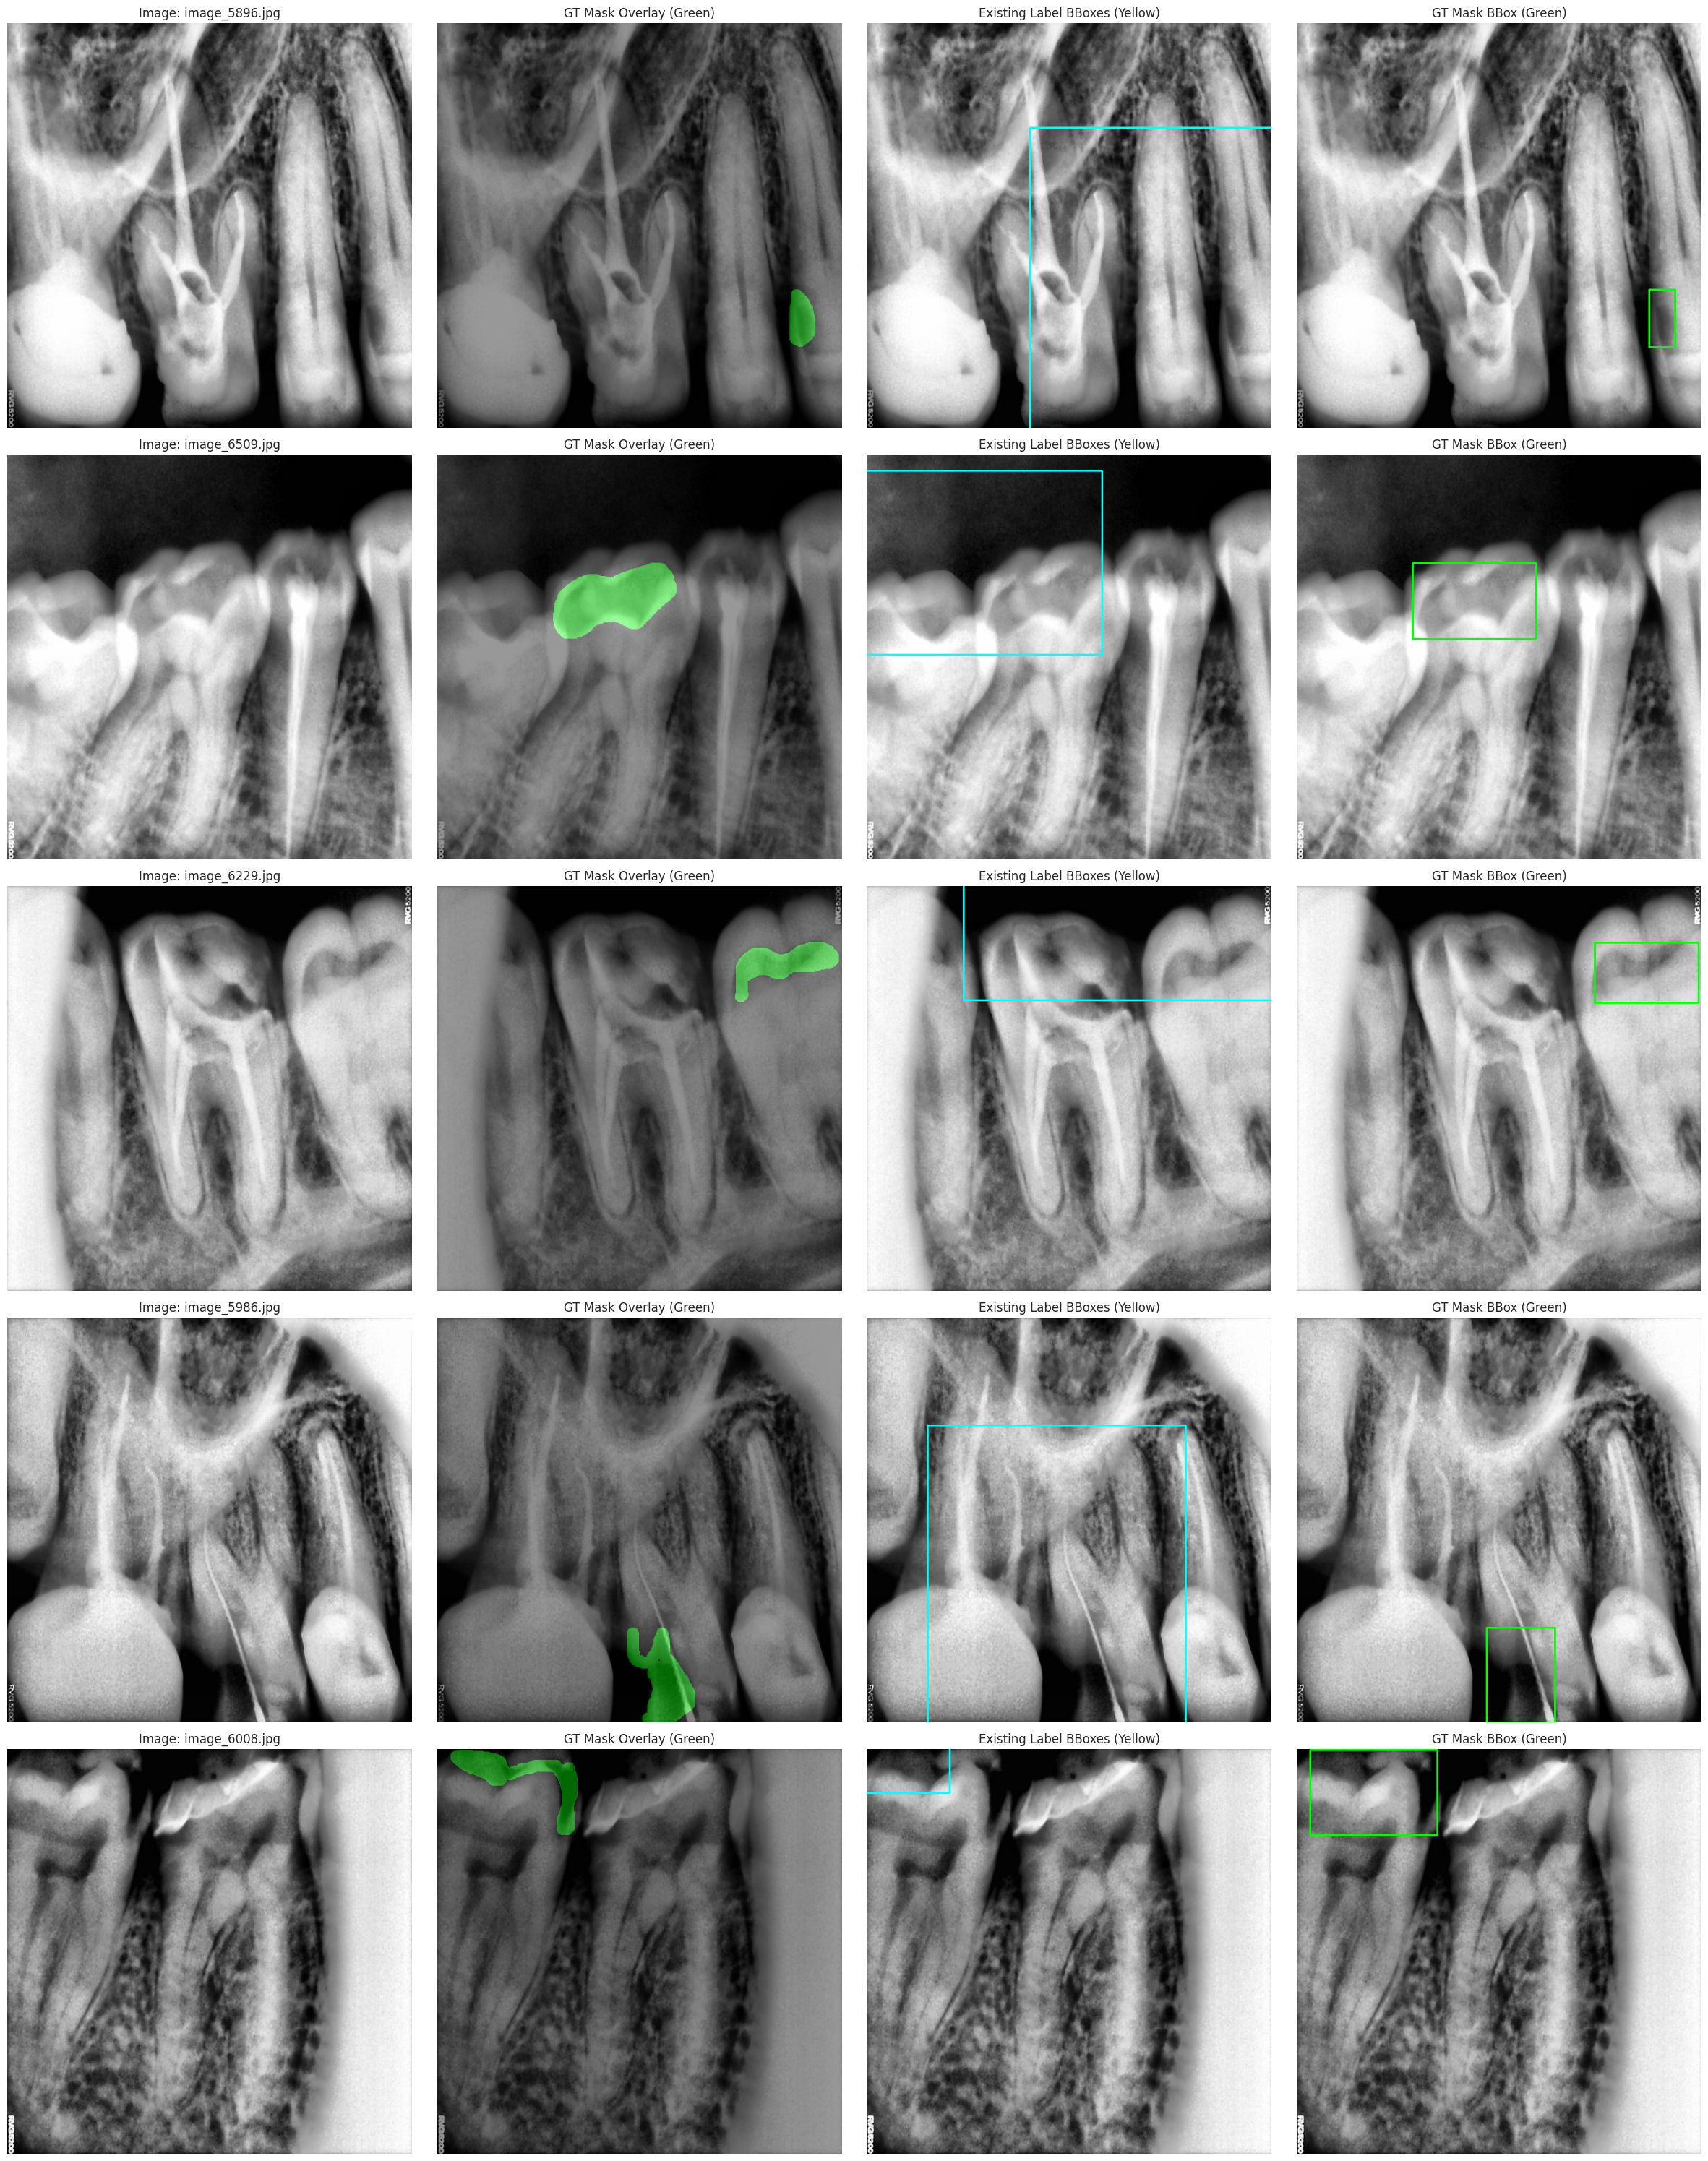

In [8]:
def parse_yolo_labels(label_path):
    """Reads YOLO format labels from a file."""
    bboxes = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    try:
                        xc, yc, w_norm, h_norm = map(float, parts[1:])
                        bboxes.append({'xc': xc, 'yc': yc, 'w': w_norm, 'h': h_norm})
                    except ValueError: pass
    return bboxes

def draw_yolo_bboxes(image, bboxes, color=(255, 255, 0), thickness=2):
    """Draws normalized YOLO boxes on an image copy."""
    img_h, img_w = image.shape[:2]
    output_image = image.copy() # Draw on a copy
    for bbox in bboxes:
        xc, yc, w_norm, h_norm = bbox['xc'], bbox['yc'], bbox['w'], bbox['h']
        box_w = w_norm * img_w; box_h = h_norm * img_h
        box_x = (xc * img_w) - (box_w / 2); box_y = (yc * img_h) - (box_h / 2)
        x1, y1 = int(box_x), int(box_y)
        x2, y2 = int(box_x + box_w), int(box_y + box_h)
        cv2.rectangle(output_image, (x1, y1), (x2, y2), color, thickness)
    return output_image

def get_bbox_from_mask(mask_gray, min_area=10):
    """Finds contours in a mask and returns the single bounding box encompassing all valid contours."""
    if mask_gray is None: return None
    _, mask_binary = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_area]
    if not valid_contours: return None
    all_points = np.vstack(valid_contours)
    x, y, w, h = cv2.boundingRect(all_points)
    return (x, y, w, h)


num_samples_to_show = 5
alpha = 0.4 # Transparency for mask overlay

if not data_info_list:
     print("Cannot display samples because data_info_list is empty.")
else:
    sample_indices = random.sample(range(len(data_info_list)), min(num_samples_to_show, len(data_info_list)))

    print(f"\nDisplaying {len(sample_indices)} samples: Image vs GT Mask vs Existing BBox vs GT BBox")
    plt.figure(figsize=(24, 6 * num_samples_to_show)) # Wider figure for 4 columns
    plot_index = 1

    for i in sample_indices:
        data_info = data_info_list[i]
        img_path = data_info['image_path']
        mask_path = data_info['mask_path']
        label_path = data_info['label_path']
        base_name = data_info['name']

        # load image
        img_bgr = cv2.imread(img_path)
        if img_bgr is None: continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # load masks
        mask_gray = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # preparing mask overlay
        gt_overlay_rgb = img_rgb.copy()
        if mask_gray is not None:
            _, mask_binary_vis = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)
            mask_colored = cv2.cvtColor(mask_binary_vis, cv2.COLOR_GRAY2BGR)
            mask_colored[mask_binary_vis > 0] = [0,255,0] # Green GT Mask
            # Need BGR version of original image for blending
            gt_overlay_bgr = cv2.addWeighted(mask_colored, alpha, img_bgr.copy(), 1 - alpha, 0)
            gt_overlay_rgb = cv2.cvtColor(gt_overlay_bgr, cv2.COLOR_BGR2RGB) # Convert final overlay to RGB

        bbox_overlay_rgb = img_rgb.copy() # Start with clean RGB image
        existing_bboxes = parse_yolo_labels(label_path)
 
        bbox_overlay_bgr = draw_yolo_bboxes(img_bgr, existing_bboxes, color=(255, 255, 0)) # Draw Yellow BGR on BGR
        bbox_overlay_rgb = cv2.cvtColor(bbox_overlay_bgr, cv2.COLOR_BGR2RGB) # Convert final to RGB


        gt_bbox_overlay_rgb = img_rgb.copy()
        gt_bbox = get_bbox_from_mask(mask_gray) # Get bbox coords (x,y,w,h)
        if gt_bbox is not None:
            x, y, w, h = gt_bbox
            cv2.rectangle(gt_bbox_overlay_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2) 


        # --- Display ---
        plt.subplot(num_samples_to_show, 4, plot_index); plot_index += 1
        plt.imshow(img_rgb); plt.title(f"Image: {base_name}.jpg"); plt.axis('off')

        plt.subplot(num_samples_to_show, 4, plot_index); plot_index += 1
        plt.imshow(gt_overlay_rgb); plt.title(f"GT Mask Overlay (Green)"); plt.axis('off')

        plt.subplot(num_samples_to_show, 4, plot_index); plot_index += 1
        plt.imshow(bbox_overlay_rgb); plt.title(f"Existing Label BBoxes (Yellow)"); plt.axis('off')

        plt.subplot(num_samples_to_show, 4, plot_index); plot_index += 1
        plt.imshow(gt_bbox_overlay_rgb); plt.title(f"GT Mask BBox (Green)"); plt.axis('off')

    plt.tight_layout()
    plt.show()

Analyzing image dimensions...


Reading image sizes:   0%|          | 0/300 [00:00<?, ?it/s]


--- Image Dimensions Summary ---
       height  width  channels
count   300.0  300.0     300.0
mean    640.0  640.0       3.0
std       0.0    0.0       0.0
min     640.0  640.0       3.0
25%     640.0  640.0       3.0
50%     640.0  640.0       3.0
75%     640.0  640.0       3.0
max     640.0  640.0       3.0

Most Common Dimensions (H x W):
height  width
640     640      300
dtype: int64

Channel Distribution:
channels
3    300
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


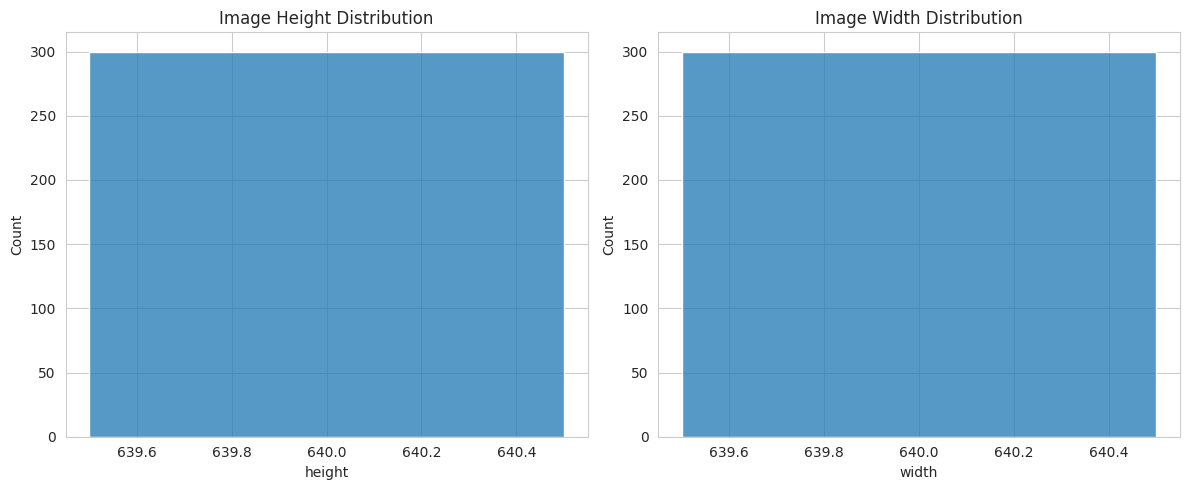

In [5]:

image_dims = []
print("Analyzing image dimensions...")

for data_info in tqdm(data_info_list, desc="Reading image sizes"):
    img_path = data_info['image_path']
    img = cv2.imread(img_path)
    h, w, c = img.shape
    image_dims.append({'filename': os.path.basename(img_path), 'height': h, 'width': w, 'channels': c})

dims_df = pd.DataFrame(image_dims)
print("\n--- Image Dimensions Summary ---")
print(dims_df.describe())
print("\nMost Common Dimensions (H x W):")
print(dims_df.groupby(['height', 'width']).size().sort_values(ascending=False).head(5))
print("\nChannel Distribution:")
print(dims_df['channels'].value_counts())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(dims_df['height'], kde=False)
plt.title('Image Height Distribution')
plt.subplot(1, 2, 2)
sns.histplot(dims_df['width'], kde=False)
plt.title('Image Width Distribution')
plt.tight_layout()
plt.show()


Analyzing GROUND TRUTH mask properties (cavity presence, count, area)...


Analyzing GT Masks:   0%|          | 0/300 [00:00<?, ?it/s]


--- GT Mask Analysis Summary ---

Images with Cavities (in GT Mask): 300
Images without Cavities (in GT Mask): 0

Cavity Count per Image (from GT Mask):
count    300.000000
mean       1.020000
std        0.140234
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: cavity_count, dtype: float64


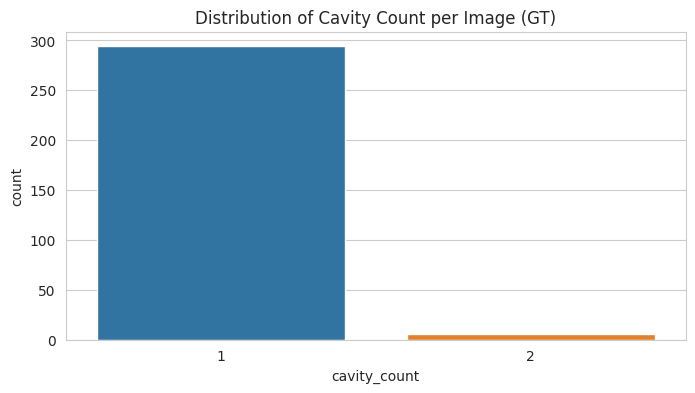

In [7]:

cavity_stats = []
print("\nAnalyzing GROUND TRUTH mask properties (cavity presence, count, area)...")

for data_info in tqdm(data_info_list, desc="Analyzing GT Masks"):
    mask_path = data_info['mask_path']
    base_name = data_info['name']

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None: continue # Basic check
    _, mask_binary = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area = 10
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) >= min_area]
    num_cavities = len(valid_contours)
    cavity_areas = [cv2.contourArea(cnt) for cnt in valid_contours]

    cavity_stats.append({
        'filename': base_name,
        'has_cavity': num_cavities > 0,
        'cavity_count': num_cavities,
        'cavity_areas': cavity_areas,
        'total_cavity_area': sum(cavity_areas)
    })

stats_df = pd.DataFrame(cavity_stats)
print("\n--- GT Mask Analysis Summary ---")

presence_counts = stats_df['has_cavity'].value_counts()
print(f"\nImages with Cavities (in GT Mask): {presence_counts.get(True, 0)}")
print(f"Images without Cavities (in GT Mask): {presence_counts.get(False, 0)}")

cavity_counts = stats_df[stats_df['has_cavity']]['cavity_count']
print("\nCavity Count per Image (from GT Mask):")
print(cavity_counts.describe())
plt.figure(figsize=(8, 4)); sns.countplot(x=cavity_counts); plt.title('Distribution of Cavity Count per Image (GT)'); plt.show()